In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm import tqdm
from syspy.skims import skims
from quetzal.model import stepmodel
from quetzal.engine import engine
from quetzal.io import excel

# Preparation of the LoS tables
## Corrects footpaths in the LoS table
## Needs PT LoS table and footpaths

In [3]:
input_path = '../input_static/spatial_'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
sm = stepmodel.read_zippedpickles(model_path + 'de_pt_los')
try:
    ae = stepmodel.read_json(model_path + 'de_pt_access_egress')
    z = stepmodel.read_json(model_path + 'de_zones')
except FileNotFoundError:
    ae = stepmodel.read_json(model_path.replace(scenario, 'base') + 'de_pt_access_egress')
    z = stepmodel.read_json(model_path.replace(scenario, 'base') + 'de_zones')
ae.zones = z.zones

pt_los: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.45s/it]


In [6]:
# make sure that time is in hours
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 3600

In [7]:
# Drop walking links that use access-egress links
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type']!='walk']

In [8]:
sm.pt_los.sample()

,origin,destination,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,time,...,business_no_car_price,business_car_price,education_no_car_price,education_car_price,buy/execute_no_car_price,buy/execute_car_price,leisure_no_car_price,leisure_car_price,accompany_no_car_price,accompany_car_price
299167,120610572,150840315,"[bus_1327107, bus_1327108, bus_1252388, bus_12...",5,418308,856,255,12360,8400,6.075278,...,14.939678,14.939678,14.939678,14.939678,14.939678,14.939678,14.939678,14.939678,14.939678,14.939678


## Compute mean distances
Based on census data: mean population-weighted distance from origin centroid to every population cluster in the destination zone

In [9]:
# Build zone-connecting footpaths
foot = engine.ntlegs_from_centroids_and_nodes(
    ae.centroids,
    ae.centroids,
    short_leg_speed=params['pt_access']['speed_bicycle'],
    long_leg_speed=params['pt_access']['speed_bicycle'],
    threshold=params['pt_access']['catchment_radius_walk'],
    n_neighbors=params['access-egress_links']['n_bicycle_between_zones'],
    coordinates_unit=ae.coordinates_unit)
foot = foot.loc[foot['distance']<=params['access-egress_links']['bicycle_max_dist']]
foot = foot.loc[foot['distance']!=0]
foot.drop_duplicates(['a', 'b', 'time'], inplace=True)
print(len(foot))
foot.sample()

47316


,a,b,rank,distance,geometry,direction,speed_factor,short_leg_speed,long_leg_speed,speed,time
7910,96729455,96729462,1,2696.884589,"LINESTRING (9.813822 50.221623, 9.849565 50.21...",access,2.596577,15,15,15.0,647.252301


In [10]:
# Build all columns of LoS table
foot = foot[['a', 'b', 'distance']]
if 'path' in sm.pt_los.columns:
    foot['index'] = foot.index
    foot['path'] = [(a,i,b) for a,i,b in zip(foot['a'], foot.index, foot['b'])]
    foot.drop('index', axis=1, inplace=True)
foot = foot.rename(columns={'a': 'origin', 'b': 'destination', 'distance': 'length'})
foot['link_path'] = [[] for _ in range(len(foot))]
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
for col in ['ntransfers', 'access_time', 'footpath_time',
            'in_vehicle_time', 'waiting_time', 'boarding_time', 'time'
           ] + [s+'_price' for s in segments]:
    if col in sm.pt_los.columns:
        foot[col] = 0
foot['route_types'] = [('walk',) for _ in range(len(foot))]
foot['route_type'] = 'walk'

In [11]:
# Clean
foot.drop_duplicates(subset=['origin', 'destination'], inplace=True)
foot.reset_index(drop=True, inplace=True)
foot.shape

(47316, 24)

In [12]:
foot.sample()

,origin,destination,length,link_path,ntransfers,access_time,footpath_time,in_vehicle_time,waiting_time,time,...,education_no_car_price,education_car_price,buy/execute_no_car_price,buy/execute_car_price,leisure_no_car_price,leisure_car_price,accompany_no_car_price,accompany_car_price,route_types,route_type
44159,84365009,84375005,20189.427411,[],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(walk,)",walk


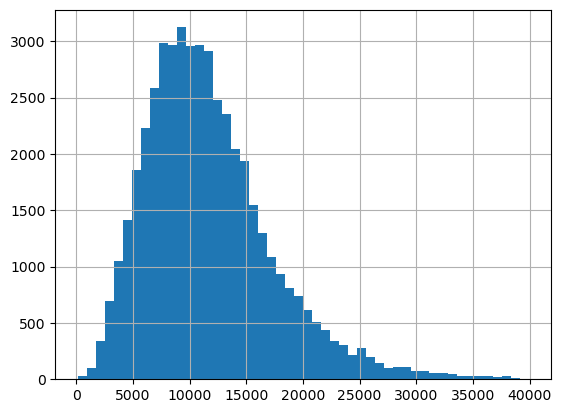

In [13]:
# Centroid distances
if manual: foot['length'].hist(bins=50)

In [14]:
# Generate time in hours
foot['length'] = foot['length'].fillna(foot['length'].mean())
foot['time'] = foot['length'] / (params['cycling']['speed'] * 1000)
foot['time'] = foot['time'].clip(lower=params['cycling']['min_time']) # add a minimum
# Apply cycling highways policy
min_popdens = params['cycling']['highways_min_popdens']
if min_popdens > 0:
    conn_zones = ae.zones.loc[(ae.zones['population'] / ae.zones['area']) >= min_popdens].index
    foot.loc[(foot['origin'].isin(conn_zones)) & (foot['destination'].isin(conn_zones)),
             'time'] *= 1 + params['cycling']['highways_speed_increase']
if 'footpath_time' in sm.pt_los.columns:
    foot['footpath_time'] = foot['time']

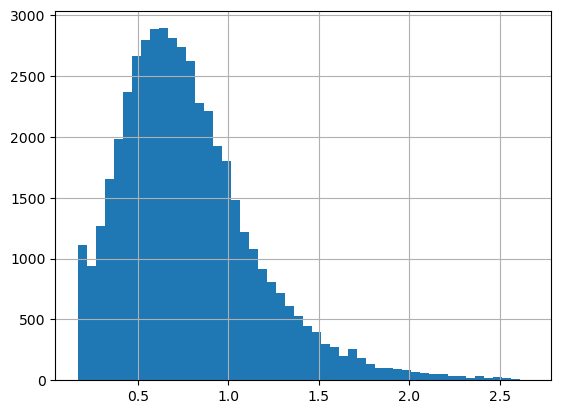

In [15]:
if manual: (foot['time']).hist(bins=50) # in h

## Save

In [16]:
# Make DataFrame lighter
cols = ['length']
foot[cols] = foot[cols].astype(int)

In [17]:
# Add to LoS table
# Align the OD sets
for df in [foot, sm.pt_los]:
    df['od'] = list(df[['origin', 'destination']].values)
    df['od'] = df['od'].apply(tuple)
foot = foot.loc[foot['od'].isin(sm.pt_los['od'])]
# Append non-motorised rows
sm.pt_los = pd.concat([sm.pt_los, foot]).reset_index(drop=True)
sm.pt_los.drop('od', axis=1, inplace=True)

In [18]:
# Drop columns from previous logit model runs
sm.pt_los.drop([col for col in sm.pt_los.columns if str(col).startswith('(')
               ] + [s+'_time' for s in segments],
               axis=1, inplace=True, errors='ignore')

In [19]:
sm.to_zippedpickles(model_path + 'de_pt_los', only_attributes=['pt_los'])

pt_los: 100%|████████████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.86s/it]
